# We're going to put a prior on height

We know empirically that the amplitudes of the seismic mode envelope roughly takes the shape of a Gaussian function. I say 'roughly', because departures from this are possible (much how glitches can cause departers from the curved asymptotic relation for mode frequencies previously). We will use the same method to account for noise in the mode amplitudes.

If we define a Gaussian function, centered at $\nu_{\rm max}$ with a width $w$ and an amplitude $A$ as

$\mathcal{G}(n, \nu_{\rm max}, w, A)$,

we can say that the amplitudes of our radial modes follow the following distribution:

$A_{n, l=0} = \mathcal{G}(n, \nu_{\rm max}, w, A) + \mathcal{N}(0, \sigma_{A})$,

where $\sigma_A$ is the noise on the amplitudes.

In general, we can describe the $A_{n, l=1,2}$ amplitude heights as a function of the radial mode amplitude height. We're going to assume that all modes amplitudes are subject to the same noise level $\sigma_{A}$, but are some fraction $V_{1, 2}$ of the radial mode amplitude. Using the nomenclature from Lund et al. (2017). Ignoring the splitting of modes due to rotation, we can describe the height of a mode as:

$H_{nl} = V_{l}^2 \mathcal{S}_{n,0} = V_{l}^2 \frac{2A_{nl}^2}{\pi\Gamma_{nl}} = \frac{2}{\pi\Gamma_{nl}} \times (V_{l} A_{nl})^2$ ,

where $\Gamma$ is the linewidth. We already perform the transformation from amplitude to height in our model as it stands. So instead of using $V_{l}^2$ to modulate $\mathcal{S}$, we'll use $V_{l}$ to directly modulate $A_{nl}$.

$A_{n, l=1} = V_{1} \mathcal{G}(n, \nu_{\rm max}, w, A) + \mathcal{N}(0, \sigma_{A})$,

$A_{n, l=2} = V_{2} \mathcal{G}(n, \nu_{\rm max}, w, A) + \mathcal{N}(0, \sigma_{A})$,

We'll set up some sensible priors for this. Something like:

$\nu_{\rm max} \sim \mathcal{N}(\nu_{\rm max, \rm prior}, 100.)$

$w \sim \mathcal{N}(0.1\times\nu_{\rm max, prior}, 10.)$

$A \sim \mathcal{N}(0.8\times p_{\rm max}, 10)$

$V_1 \sim \mathcal{N}(1.2, .5)$

$V_2 \sim \mathcal{N}(0.7, .5)$

$\sigma_{A} \sim \gamma(\alpha=1., beta=0.5)$

where we've taken the mean values for $V_{1, 2}$ from what we roughly expect them to be for the *Kepler* mission from the LEGACY data, and $p_{\rm max}$ is the maximum power value in the data we're fitting to. If we're having trouble with these values we can do a proper fit for them from the literature amplitudes, but I expect we'll be okay.

Note: The $\nu_{\rm max}$ here doubles as an entry in the asympotic mode frequency model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [2]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i, theano=True):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3. * tt.cos(i)**2 - 1.)**2)
        eps2 = tt.set_subtensor(eps2[1], (3./8.)*tt.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        if not theano:
            return eps.eval()
        return eps
            

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i, theano)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

    # Small separations are fractional
    def asymptotic(self, n, numax, deltanu, alpha, epsilon, d=0.): 
        nmax = (numax / deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * deltanu

    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, deltanu, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon, -d02)

    def gaussian(self, freq, numax, w, A):
        return A * np.exp(-0.5 * (freq - numax)**2 / w**2)

    def A0(self, f, p):
        numax, w, A, V1, V2 = p
        return self.gaussian(f, numax, w, A)
    
    def A1(self, f, p):
        numax, w, A, V1, V2 = p
        return self.gaussian(f, numax, w, A)*V1        
    
    def A2(self, f, p):
        numax, w, A, V1, V2 = p
        return self.gaussian(f, numax, w, A)*V2      

In [3]:
nmodes = 4
nbase = 16
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

In [4]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

In [5]:
mod = model(ff, n0_, n1_, n2_)

In [6]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]

f0_true = mod.f0(init_f)
f1_true = mod.f1(init_f)
f2_true = mod.f2(init_f)

sigma0_ = 1.5
sigma1_ = 2.0
sigma2_ = .5
f0_ = mod.f0(init_f) + np.random.randn(len(f0_true)) * sigma0_
f1_ = mod.f1(init_f) + np.random.randn(len(f1_true)) * sigma1_
f2_ = mod.f2(init_f) + np.random.randn(len(f2_true)) * sigma2_

In [7]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

And now lets reset the model for the new frequency range...

In [8]:
mod = model(f, n0_, n1_, n2_)

In [9]:
w_ = (0.25 * numax_)/2.355
V1_ = 1.2
V2_ = 0.7
A_ = 50.
init_h =[numax_,   #numax
         w_,       #envelope width
         A_,       #envelope amplitude
         V1_,      #dipole visibility
         V2_       #ocotopole visibility
        ]
amps = [mod.A0(f0_, init_h),
        mod.A1(f1_, init_h),
        mod.A2(f2_, init_h)]

In [10]:
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       np.ones(len(f0_)) * 2.0,     # l0 widths
       np.ones(len(f1_)) * 2.0,     # l1 widths
       np.ones(len(f2_)) * 2.0,     # l2 widths
       np.sqrt(amps[0]**2 * 2.0 / np.pi / 2.0) ,# l0 heights
       np.sqrt(amps[1]**2 * 2.0 / np.pi / 2.0) ,# l1 heights
       np.sqrt(amps[2]**2 * 2.0 / np.pi / 2.0) ,# l2 heights
       1.,       # splitting
       np.pi/4.,                    # inclination angle
       1.                           # background parameters
        ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

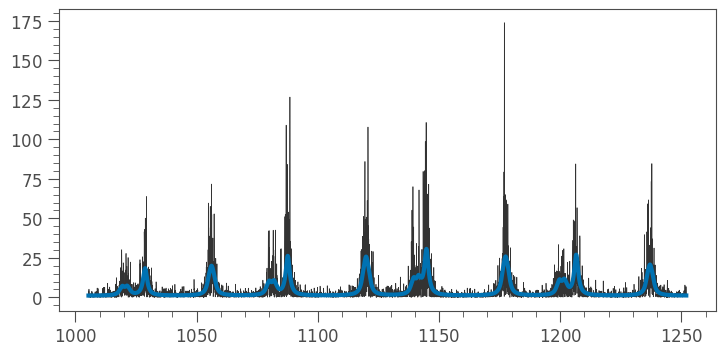

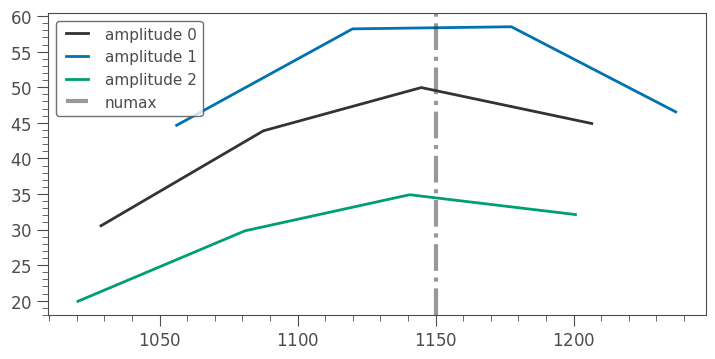

In [11]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(f0_, amps[0], label='amplitude 0', lw=2)
    ax.plot(f1_, amps[1], label='amplitude 1', lw=2)
    ax.plot(f2_, amps[2], label='amplitude 2', lw=2)
    ax.axvline(numax_, lw=3, ls='-.', label='numax', alpha=.5)
    ax.legend()
    plt.show()    

## First lets fit the mode heights...

In [12]:
pm_model = pm.Model()

with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    w = pm.Normal('w', w_, 1., testval=w_)
    A = pm.Normal('A', A_, 10., testval=A_)
    V1 = pm.Normal('V1', V1_, 0.1, testval=V1_)
    V2 = pm.Normal('V2', V2_, 0.1, testval=V2_)
    
    a0 = pm.Normal('a0', mod.A0(f0_, [numax, w, A, V1, V2]), 1., shape=len(f0_)) 
    a1 = pm.Normal('a1', mod.A1(f0_, [numax, w, A, V1, V2]), 1., shape=len(f1_)) 
    a2 = pm.Normal('a2', mod.A2(f0_, [numax, w, A, V1, V2]), 1., shape=len(f2_)) 
    
    pm.Normal('like0', a0, .1, observed=amps[0])
    pm.Normal('like1', a1, .1, observed=amps[1])
    pm.Normal('like2', a2, .1, observed=amps[2])    
    
    trace = pm.sample(tune=1000,chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [a2, a1, a0, V2, V1, A, w, numax]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1092.42draws/s]


In [13]:
pm.summary(trace)

mean        sd  mc_error      hpd_2.5     hpd_97.5        n_eff  \
numax  1146.705326  0.874808  0.012353  1145.019708  1148.403440  5180.327172   
w       123.210711  0.945944  0.013151   121.384377   124.970003  4687.905562   
A        49.709525  0.585225  0.014698    48.641605    50.936028  1910.965817   
V1        1.213109  0.017727  0.000400     1.175900     1.244192  2133.101957   
V2        0.691661  0.013756  0.000283     0.664840     0.717916  2625.796641   
a0__0    30.544043  0.098570  0.001608    30.351679    30.738702  4445.964556   
a0__1    43.880635  0.099502  0.001373    43.675129    44.062844  5887.084546   
a0__2    49.952557  0.098105  0.001619    49.769420    50.140971  3606.953645   
a0__3    44.899473  0.097737  0.001718    44.720289    45.100026  3184.558564   
a1__0    44.588686  0.103239  0.001686    44.382890    44.791386  5543.479275   
a1__1    58.161694  0.098730  0.001411    57.960133    58.346367  5283.736131   
a1__2    58.520851  0.095470  0.001402    58.341964    58.718490  4962.203563   
a1__3    46.606717  0.098772  0.001443    46.411312    46.783995  5373.663481   
a2__0    19.936779  0.094937  0.001442    19.749682    20.119698  3726.835925   
a2__1    29.832228  0.103465  0.001727    29.629345    30.040228  3552.031733   
a2__2    34.891837  0.098662  0.001544    34.690563    35.067134  4887.874602   
a2__3    32.093291  0.098536  0.001649    31.897497    32.278167  4407.474866   

           Rhat  
numax  0.999411  
w      0.999772  
A      0.999488  
V1     0.999534  
V2     0.999283  
a0__0  0.999852  
a0__1  0.999286  
a0__2  1.000031  
a0__3  0.999039  
a1__0  0.999288  
a1__1  0.999573  
a1__2  0.999133  
a1__3  0.999160  
a2__0  0.999375  
a2__1  0.999577  
a2__2  0.999264  
a2__3  0.999447

In [14]:
    ax.plot(f0_, amps[0], label='amplitude 0', lw=2)
    ax.plot(f1_, amps[1], label='amplitude 1', lw=2)
    ax.plot(f2_, amps[2], label='amplitude 2', lw=2)
    ax.axvline(numax_, lw=3, ls='-.', label='numax', alpha=.5)

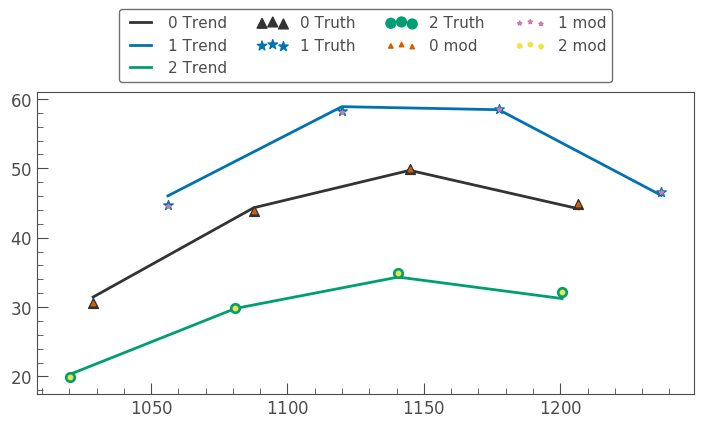

In [15]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'w', 'A', 'V1','V2']]
    resls = [np.median(trace[label],axis=0) for label in ['a0','a1','a2']]
       
    ax.plot(f0_, mod.A0(f0_, res), label='0 Trend',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, res), label='1presi Trend',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, res), label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_, amps[0], marker='^',label='0 Truth',  s=50, zorder=2)
    ax.scatter(f1_, amps[1], marker='*',label='1 Truth',  s=50, zorder=2)
    ax.scatter(f2_, amps[2], marker='o',label='2 Truth',  s=50, zorder=2)   

    ax.scatter(f0_, resls[0], marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(f1_, resls[1], marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(f2_, resls[2], marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    

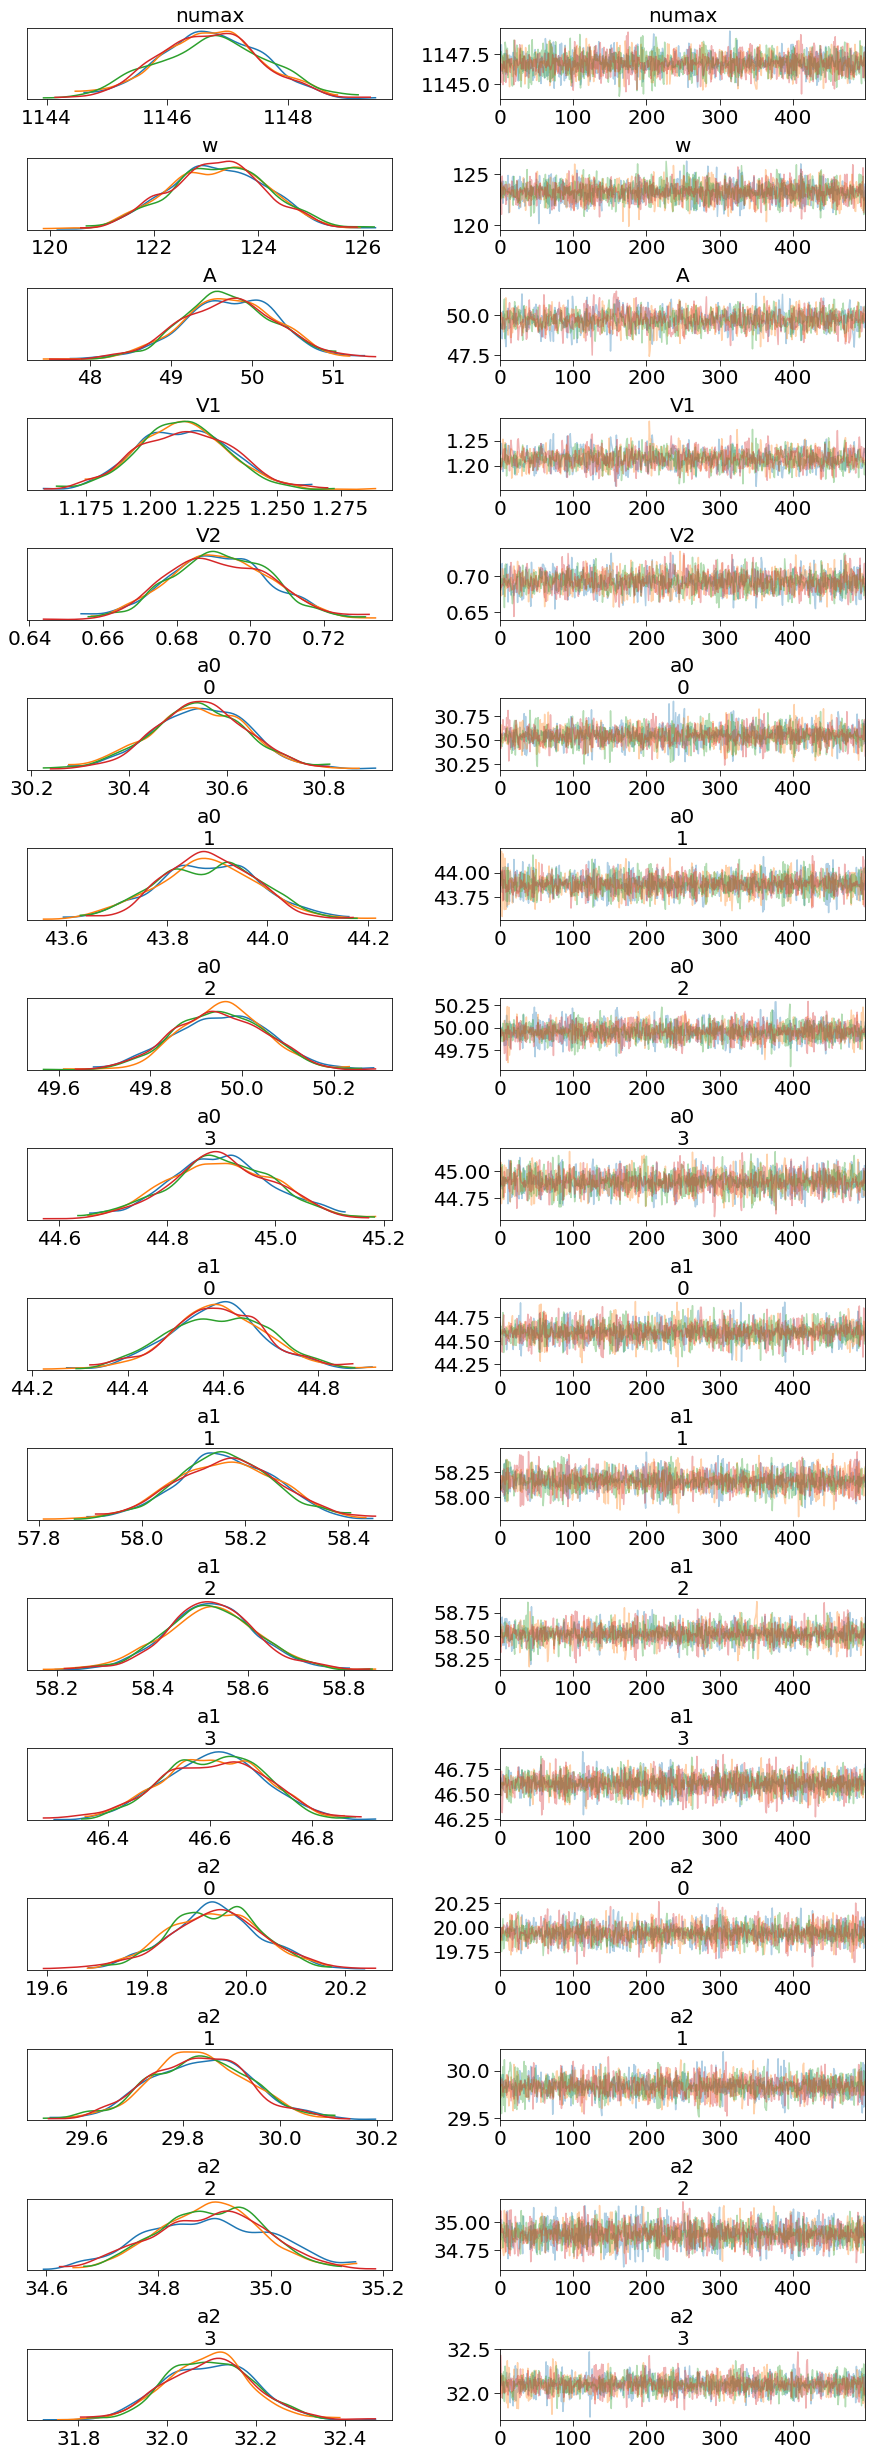

In [16]:
pm.traceplot(trace);

Works well and seemingly at a tiny expense. Let's try and put this into the real thing.

# Now lets try and fit this

In [17]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    deltanu = pm.Normal('deltanu', deltanu_, 1., testval=deltanu_)
    alpha = pm.Normal('alpha', alpha_, 0.001, testval=alpha_)
    epsilon = pm.Normal('epsilon', epsilon_, 1., testval=epsilon_)
    d01     = pm.Normal('d01', d01_, 0.01, testval=d01_)   
    d02     = pm.Normal('d02', d02_, 0.01, testval=d02_)
    
    sigma0 = pm.HalfNormal('sigma0', 1., testval=1.5)
    sigma1 = pm.HalfNormal('sigma1', 1., testval=2.)
    sigma2 = pm.HalfNormal('sigma2', 1., testval=.5)

    f0 = pm.Normal('f0', mod.f0([numax, deltanu, alpha, epsilon, d01, d02]), sigma0, shape=len(f0_))
    f1 = pm.Normal('f1', mod.f1([numax, deltanu, alpha, epsilon, d01, d02]), sigma1, shape=len(f0_))
    f2 = pm.Normal('f2', mod.f2([numax, deltanu, alpha, epsilon, d01, d02]), sigma2, shape=len(f0_))

    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))

    w = pm.Normal('w', w_, 1., testval=w_)
    A = pm.Normal('A', A_, 1., testval=A_)
    V1 = pm.Normal('V1', V1_, 0.1, testval=V1_)
    V2 = pm.Normal('V2', V2_, 0.1, testval=V2_)
    
    a0 = pm.Normal('a0', mod.A0(f0_, [numax, w, A, V1, V2]), 1., shape=len(f0_)) 
    a1 = pm.Normal('a1', mod.A1(f0_, [numax, w, A, V1, V2]), 1., shape=len(f1_)) 
    a2 = pm.Normal('a2', mod.A2(f0_, [numax, w, A, V1, V2]), 1., shape=len(f2_))     
    
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = BNormal('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [18]:
with pm_model:
    trace = pm.sample(tune=1000, chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, cosi, xsplit, a2, a1, a0, V2, V1, A, w, g2, g1, g0, f2, f1, f0, sigma2, sigma1, sigma0, d02, d01, epsilon, alpha, deltanu, numax]
Sampling 4 chains: 100%|██████████| 6000/6000 [38:46<00:00,  2.28draws/s]  
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
pm.summary(trace)

mean            sd      mc_error       hpd_2.5      hpd_97.5  \
numax    1.149875e+03  9.823267e-01  2.043979e-02  1.147868e+03  1.151709e+03   
deltanu  5.981934e+01  3.472584e-01  1.178934e-02  5.919225e+01  6.052645e+01   
alpha    9.896868e-03  9.887415e-04  2.338823e-05  8.066172e-03  1.180071e-02   
epsilon  1.182217e+00  1.075572e-01  3.660357e-03  9.643722e-01  1.374654e+00   
d01      4.985767e-01  8.655412e-03  1.892259e-04  4.813774e-01  5.153484e-01   
d02      8.742486e-02  9.070289e-03  2.214874e-04  7.091486e-02  1.066896e-01   
f0__0    1.028948e+03  9.644394e-02  3.535791e-03  1.028772e+03  1.029130e+03   
f0__1    1.088379e+03  2.223750e-01  2.093590e-02  1.087724e+03  1.088579e+03   
f0__2    1.145623e+03  2.288639e-01  2.286875e-02  1.145215e+03  1.145786e+03   
f0__3    1.206414e+03  3.870912e-02  3.768305e-03  1.206366e+03  1.206486e+03   
f1__0    1.056229e+03  1.908832e-01  4.997258e-03  1.055831e+03  1.056589e+03   
f1__1    1.119989e+03  2.154273e-01  9.204084e-03  1.119591e+03  1.120391e+03   
f1__2    1.177360e+03  2.307933e-01  8.653181e-03  1.176951e+03  1.177823e+03   
f1__3    1.236975e+03  1.843467e-01  4.172837e-03  1.236602e+03  1.237321e+03   
f2__0    1.023513e+03  5.575728e-01  2.179829e-02  1.022519e+03  1.024622e+03   
f2__1    1.084342e+03  3.420160e-01  2.561016e-02  1.083628e+03  1.084889e+03   
f2__2    1.142565e+03  1.833329e-01  8.155655e-03  1.142147e+03  1.142884e+03   
f2__3    1.203690e+03  1.804321e-01  5.790668e-03  1.203327e+03  1.204032e+03   
w        1.220941e+02  9.859301e-01  1.934752e-02  1.203432e+02  1.241269e+02   
A        4.900017e+01  9.777329e-01  3.132103e-02  4.707125e+01  5.092275e+01   
V1       2.429524e-01  1.378626e-02  3.101885e-04  2.124777e-01  2.672124e-01   
V2       2.666992e-01  1.445016e-02  4.834630e-04  2.371301e-01  2.941190e-01   
a0__0    2.977562e+01  1.216002e+00  2.955834e-02  2.741324e+01  3.219670e+01   
a0__1    4.295876e+01  1.332783e+00  3.557769e-02  4.041490e+01  4.565222e+01   
a0__2    4.892200e+01  1.371932e+00  3.829343e-02  4.629773e+01  5.157649e+01   
a0__3    4.393976e+01  1.330335e+00  3.724737e-02  4.121237e+01  4.647129e+01   
a1__0    8.610174e+00  3.458507e-01  8.253124e-03  7.978031e+00  9.272099e+00   
a1__1    1.025834e+01  4.275126e-01  1.040731e-02  9.415778e+00  1.111555e+01   
a1__2    1.018602e+01  4.328319e-01  1.157757e-02  9.357349e+00  1.102172e+01   
a1__3    9.593770e+00  3.869552e-01  9.043705e-03  8.882993e+00  1.036359e+01   
...               ...           ...           ...           ...           ...   
sigma2   1.259656e+00  4.989387e-01  1.673598e-02  4.339848e-01  2.196860e+00   
g0__0    2.458718e-02  1.121245e-02  4.192808e-04  5.119480e-03  4.514419e-02   
g0__1    2.821836e-03  6.161277e-03  5.235262e-04  2.847755e-06  1.783713e-02   
g0__2    1.823519e-04  1.903307e-04  5.814390e-06  2.624994e-09  5.290403e-04   
g0__3    2.732370e-04  3.808870e-04  1.502963e-05  3.576576e-07  9.162788e-04   
g1__0    1.481609e+00  2.460084e-01  8.788071e-03  1.018256e+00  1.978888e+00   
g1__1    1.477992e+00  2.087232e-01  5.227393e-03  1.091055e+00  1.890866e+00   
g1__2    1.490845e+00  2.026022e-01  4.623901e-03  1.140905e+00  1.915171e+00   
g1__3    1.844095e+00  2.623253e-01  5.519079e-03  1.356036e+00  2.357068e+00   
g2__0    4.800672e+00  9.196021e-01  3.124169e-02  3.005388e+00  6.540157e+00   
g2__1    2.762857e+00  5.498488e-01  3.158653e-02  1.653751e+00  3.829208e+00   
g2__2    1.679666e+00  2.190905e-01  5.301737e-03  1.290490e+00  2.134056e+00   
g2__3    2.842845e+00  4.660383e-01  2.140950e-02  1.956501e+00  3.815946e+00   
h0__0    2.948070e+04  1.795242e+04  6.164609e+02  7.778187e+03  6.716189e+04   
h0__1    5.416040e+06  1.697924e+07  6.351342e+05  2.051646e+04  2.139634e+07   
h0__2    6.205417e+08  1.656966e+10  5.917154e+08  9.284267e+05  9.244406e+07   
h0__3    2.853987e+07  1.323234e+08  3.974413e+06  2.167221e+05  7.066017e+07   
h1__0    3.286048e+01  6.498088e+00  2.261651e-0

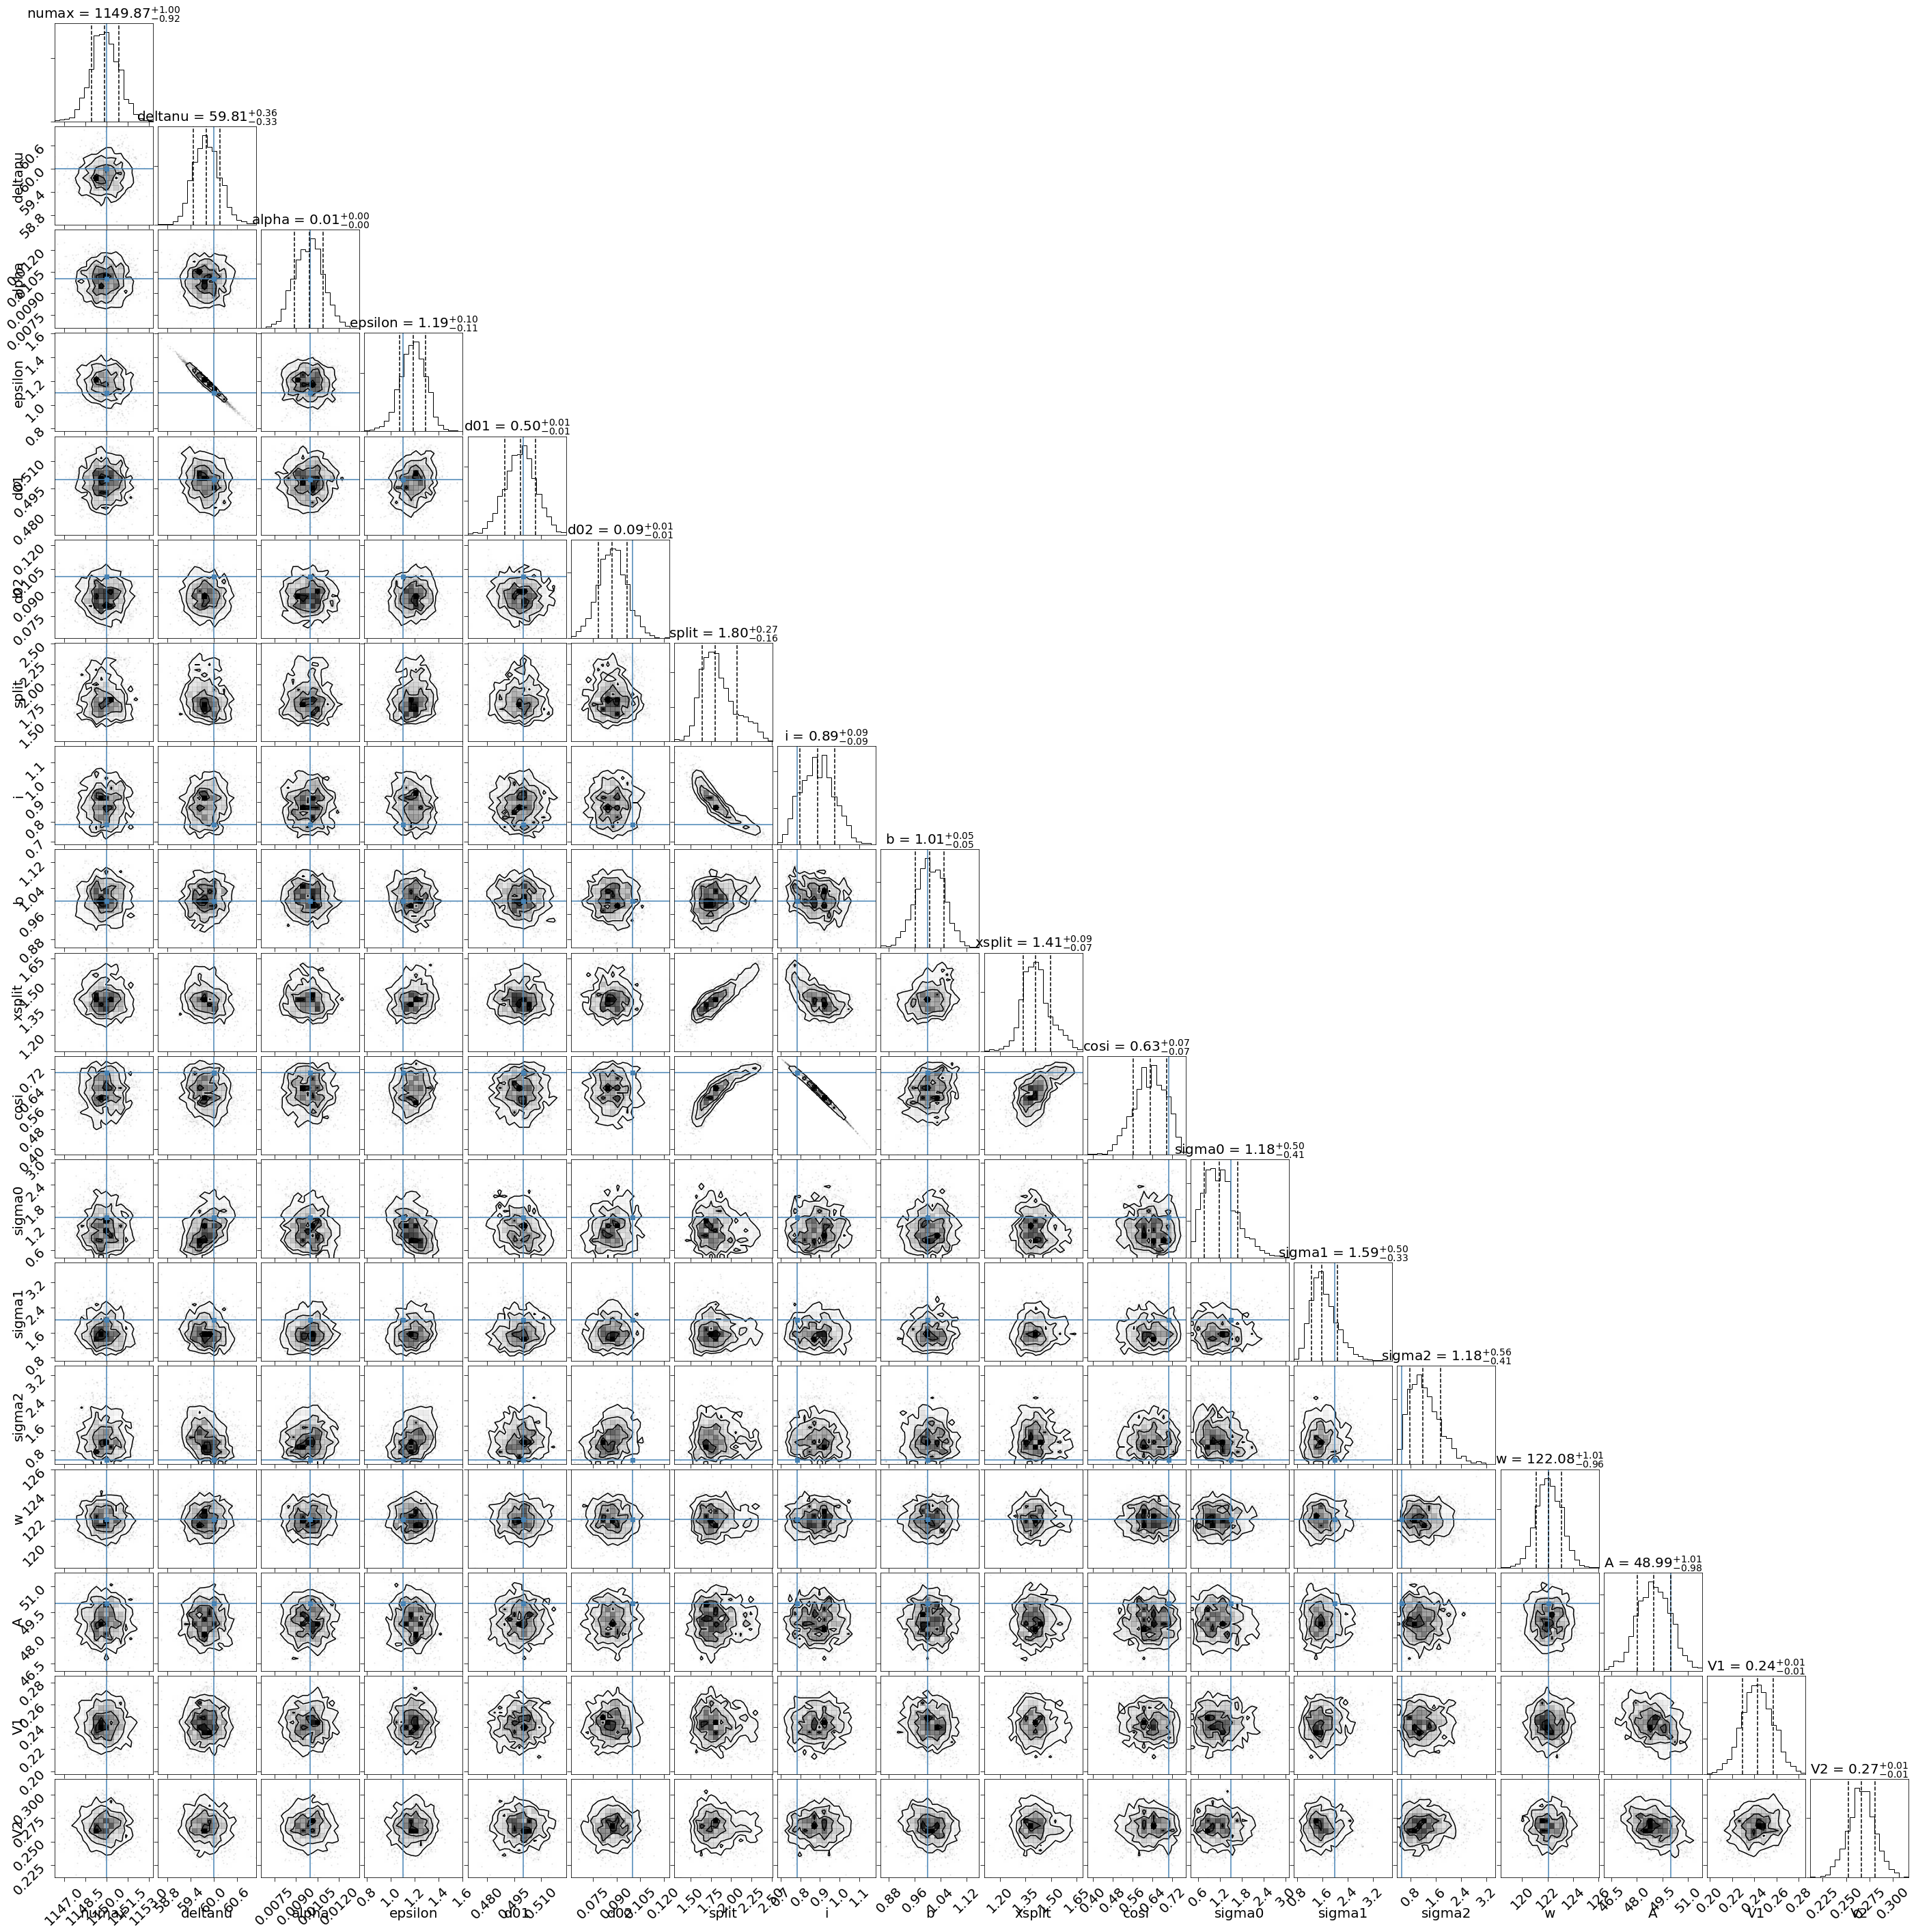

In [20]:
labels = ['numax','deltanu','alpha','epsilon','d01','d02',
          'split','i','b','xsplit','cosi','sigma0','sigma1','sigma2',
          'w','A','V1','V2']
chain = np.array([trace[label] for label in labels])
truths = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_,
         init_m[9], init_m[10], init_m[11], init_m[9]*np.sin(init_m[10]), np.cos(init_m[10]),
         sigma0_, sigma1_, sigma2_, w_, A_, V1_, V2_]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], show_titles=True)
plt.show()

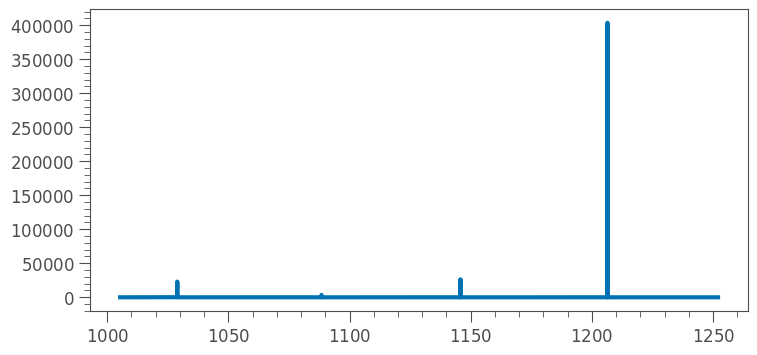

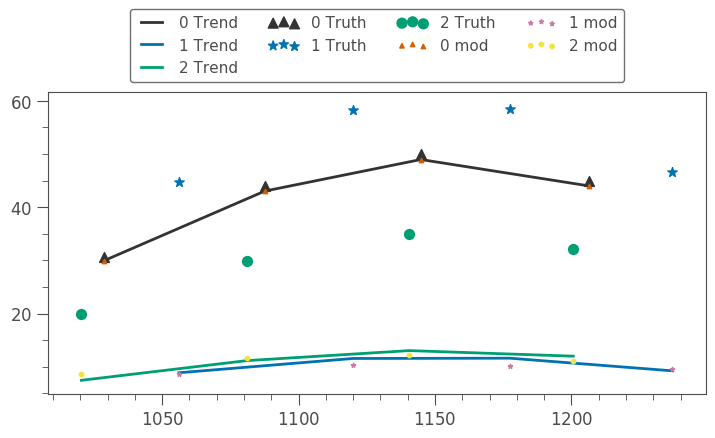

In [21]:
with plt.style.context(ms.ms):
    res_m = [np.median(trace[label], axis=0) for label in ['f0','f1','f2','g0','g1','g2',
                                                         'h0','h1','h2','split','i','b']]
    plt.plot(f, p)
    plt.plot(f, mod.model(res_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'w', 'A', 'V1','V2']]
    resls = [np.median(trace[label],axis=0) for label in ['a0','a1','a2']]
       
    ax.plot(f0_, mod.A0(f0_, res), label='0 Trend',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, res), label='1 Trend',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, res), label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_, amps[0], marker='^',label='0 Truth',  s=50, zorder=2)
    ax.scatter(f1_, amps[1], marker='*',label='1 Truth',  s=50, zorder=2)
    ax.scatter(f2_, amps[2], marker='o',label='2 Truth',  s=50, zorder=2)   

    ax.scatter(f0_, resls[0], marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(f1_, resls[1], marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(f2_, resls[2], marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    

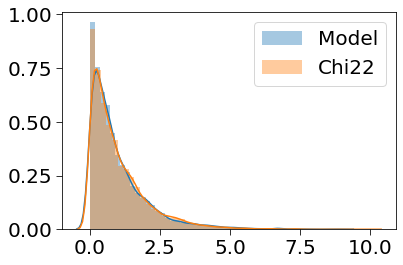

In [22]:
residual = p/mod.model(res_m, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()

## Let's investigate any divergences:

In [23]:
def pairplot_divergence(x, y, trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(x, y, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(x[divergent], y[divergent], 'o', color=divergence_color)
    return ax

def divergence_corner(trace, labels, entry=0):
    chain = np.array([trace[label] for label in labels])
    if len(chain.shape) > 2:
        chain = chain[:,:,entry]
        print('Only showing the entry [{}] for multi-parameter labels'.format(entry))
        titleadd = '[{}]'.format(entry)
    else:
        titleadd = ''
    
    K = len(chain)
    factor = 2.0           # size of one side of one panel
    lbdim = 0.5 * factor   # size of left/bottom margin
    trdim = 0.2 * factor   # size of top/right margin
    whspace = 0.05         # w/hspace size
    plotdim = factor * K + factor * (K - 1.) * whspace
    dim = lbdim + plotdim + trdim

    # Create a new figure if one wasn't provided.
    fig, axes = plt.subplots(K, K, figsize=(dim, dim))

    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim
    fig.subplots_adjust(left=lb, bottom=lb, right=tr, top=tr,
                        wspace=whspace, hspace=whspace)

    hist_kwargs = dict()
    hist_kwargs["color"] = hist_kwargs.get("color", 'k')
    for i, x in enumerate(chain):
        ax = axes[i,i]
        bins_1d = int(max(1, 20.))
        n, _, _ = ax.hist(x, bins=bins_1d, histtype='step')       


        title = "{}{}".format(labels[i], titleadd)
        ax.set_title(title)    

        for j, y in enumerate(chain):
            ax = axes[i, j]

            if j > i:    
                ax.set_frame_on(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            elif j == i:
                ax.set_xticks([])
                ax.set_yticks([])            
                continue    

            ax = pairplot_divergence(y, x, trace, ax=ax)

            if i < K - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])   

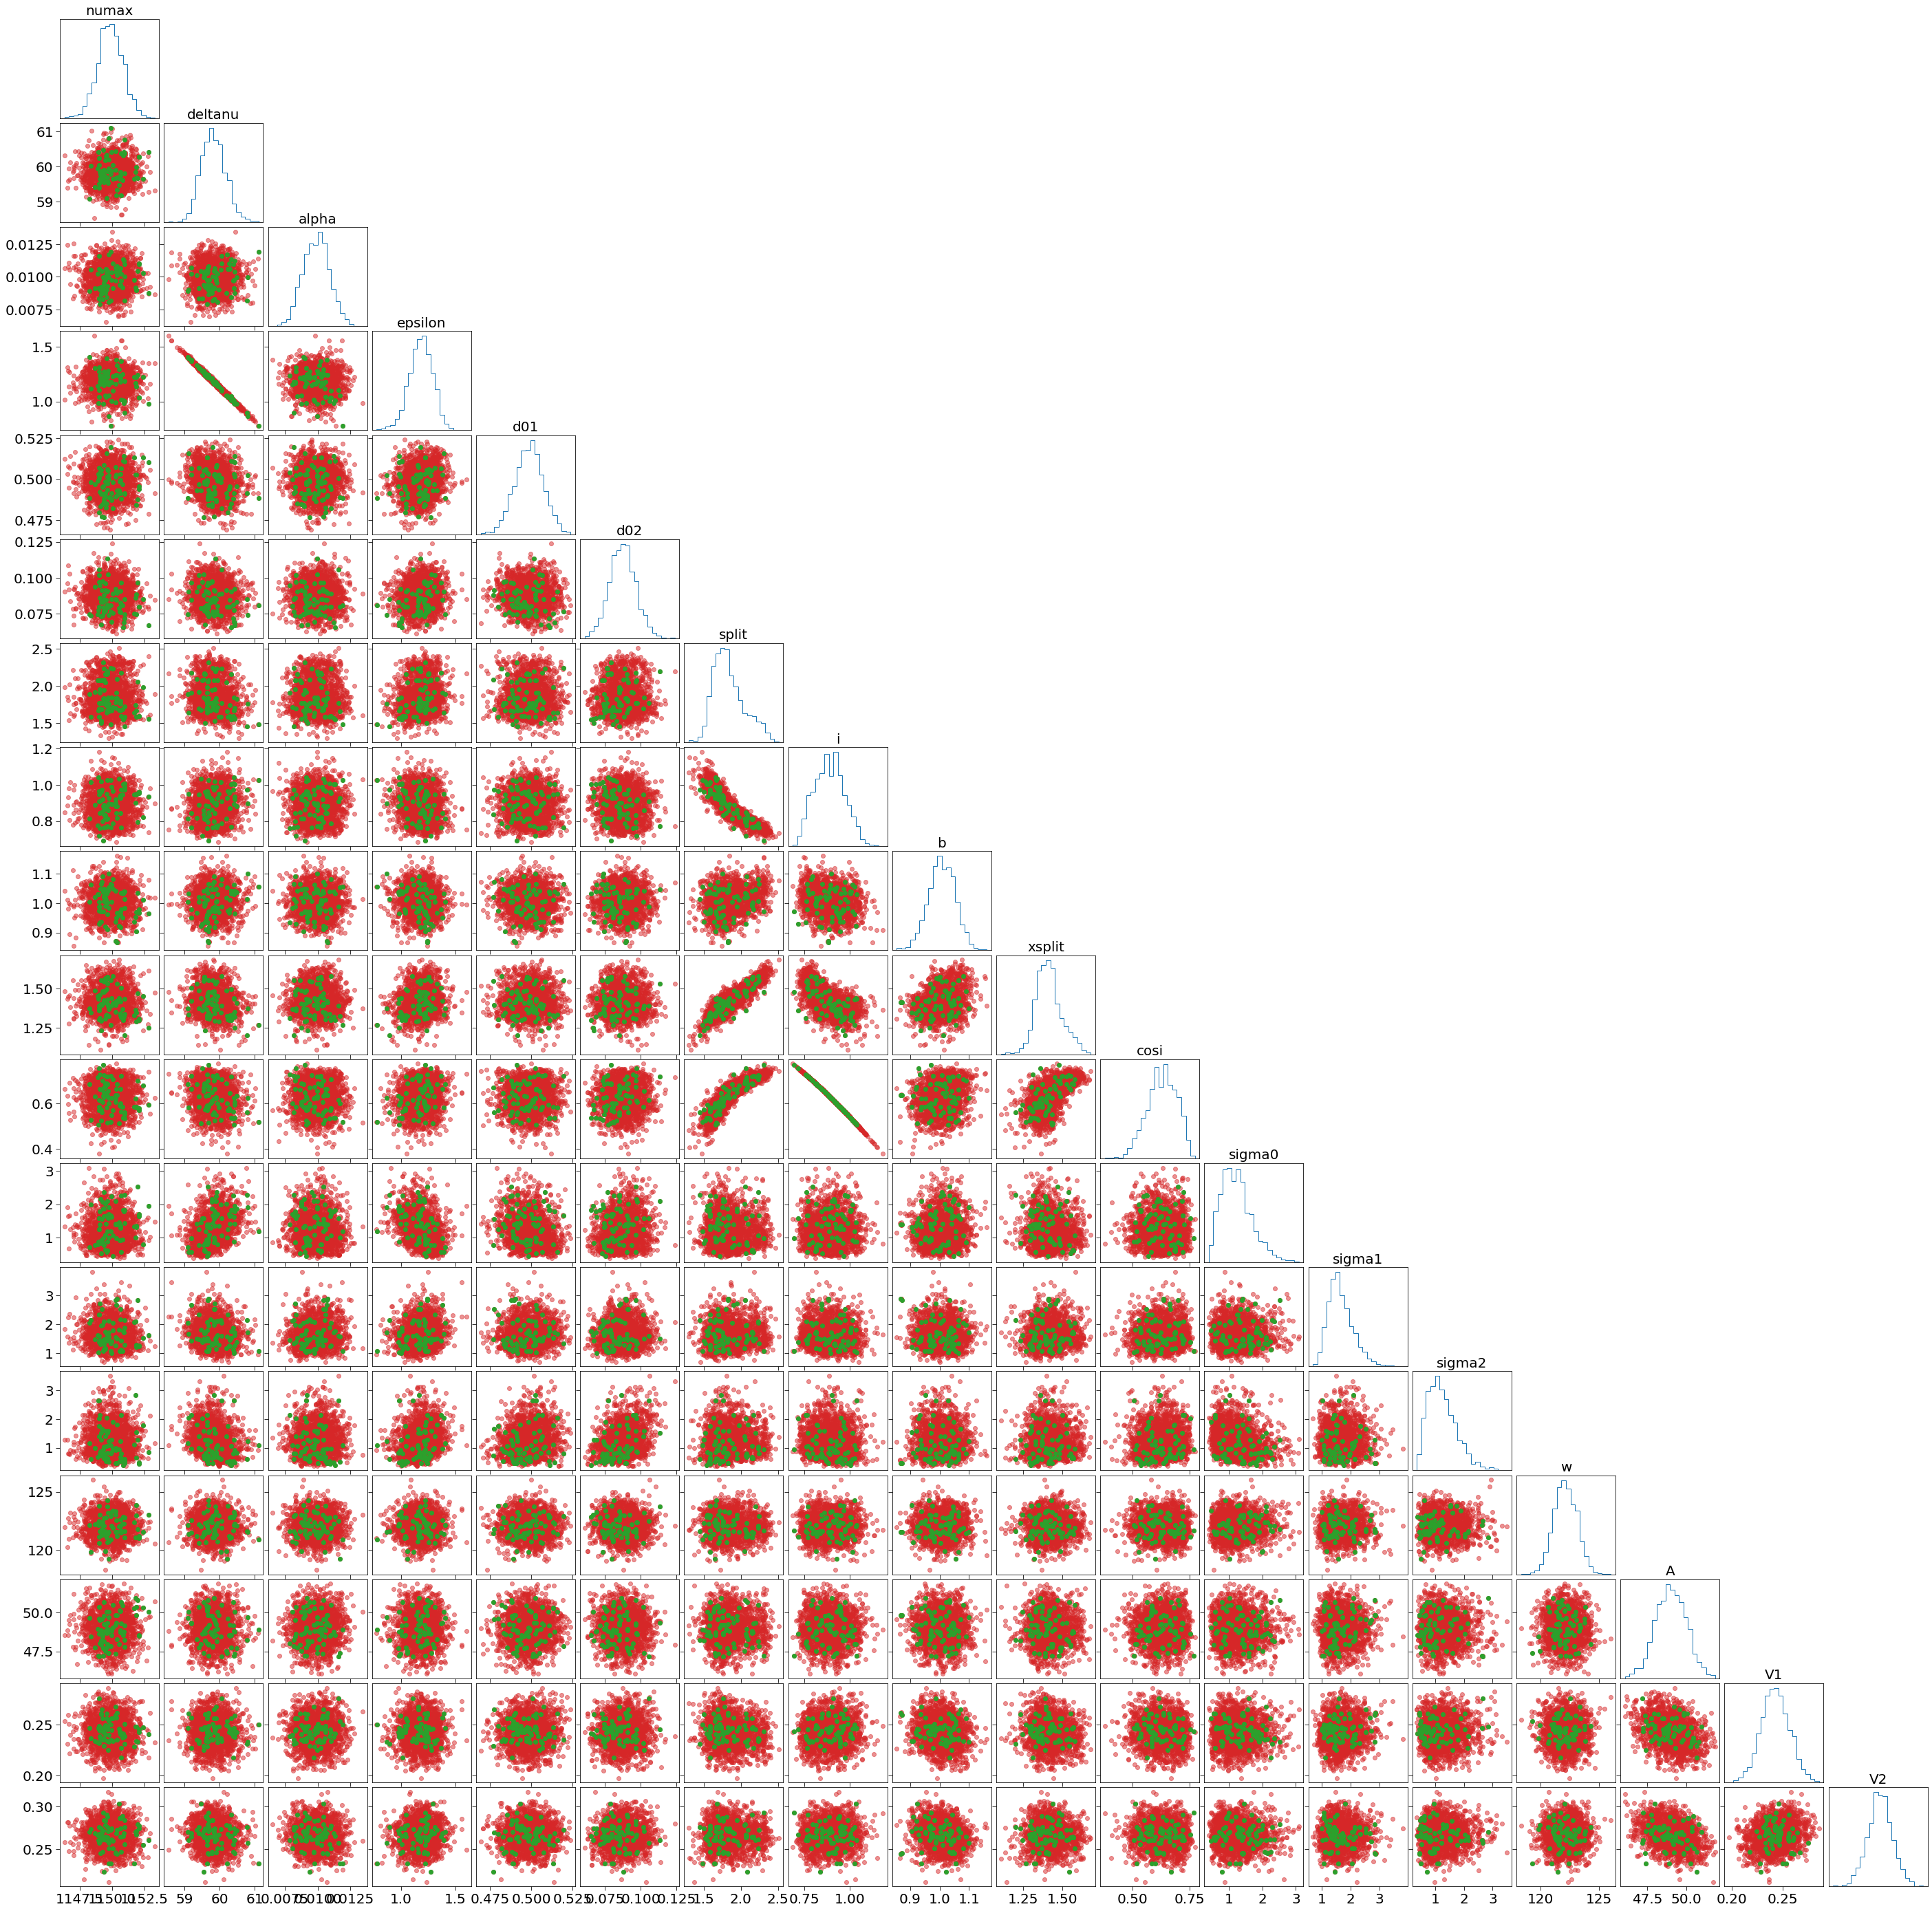

In [24]:
labels = ['numax','deltanu','alpha','epsilon','d01','d02',
          'split','i','b','xsplit','cosi','sigma0','sigma1','sigma2',
          'w','A','V1','V2']
divergence_corner(trace, labels)

/home/oliver/.local/lib/python3.7/site-packages/arviz/plots/traceplot.py:156: SyntaxWarning: max_plots is smaller than the number of variables to plot generating only max_plots traceplots
  SyntaxWarning,


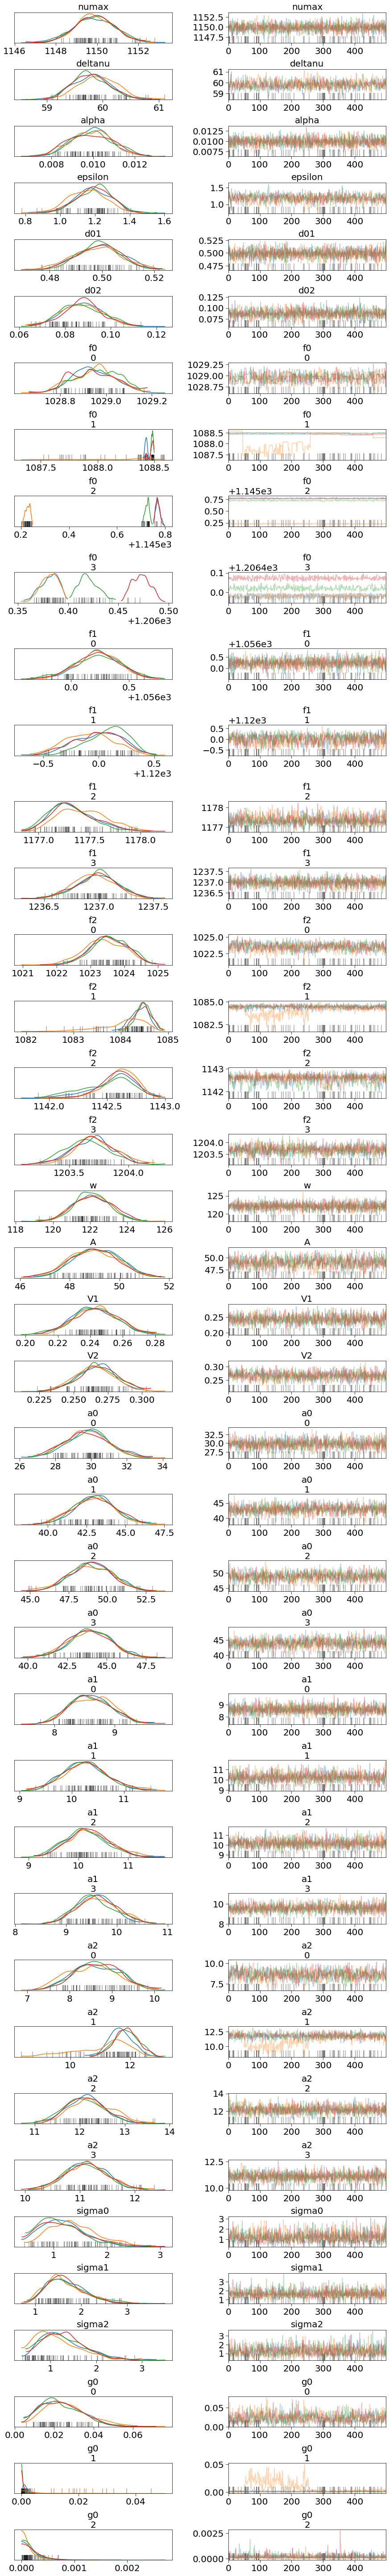

In [25]:
pm.traceplot(trace)
plt.show()